In [1]:
import pandas as pd

url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
tables = pd.read_html(url, attrs={'class': 'wikitable'})
symbols = tables[0]['Symbol']
print("Components:", ", ".join(symbol.ljust(4) for symbol in symbols))

Components: MMM , AXP , AMGN, AMZN, AAPL, BA  , CAT , CVX , CSCO, KO  , DIS , GS  , HD  , HON , IBM , JNJ , JPM , MCD , MRK , MSFT, NKE , NVDA, PG  , CRM , SHW , TRV , UNH , VZ  , V   , WMT 


In [7]:
tables[0]

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,1.83%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,4.12%
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,3.76%
3,Amazon,NASDAQ,AMZN,Retailing,2024-02-26,NaN,3.02%
4,Apple,NASDAQ,AAPL,Information technology,2015-03-19,NaN,3.33%
5,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,2.15%
6,Caterpillar,NYSE,CAT,Construction and mining,1991-05-06,NaN,5.41%
7,Chevron,NYSE,CVX,Petroleum industry,2008-02-19,Also 1930-07-18 to 1999-11-01,2.18%
8,Cisco,NASDAQ,CSCO,Information technology,2009-06-08,NaN,0.82%
9,Coca-Cola,NYSE,KO,Drink industry,1987-03-12,Also 1932-05-26 to 1935-11-20,0.86%


In [2]:
import numpy as np
import yfinance as yf

start_date = "2020-01-01"
end_date = "2024-12-31"

# Download and interpolate data
df = yf.download(symbols.tolist(), start=start_date, end=end_date)["Adj Close"].interpolate()

# Daily log returns
df_returns = np.log(df / df.shift(1)).dropna()

[*********************100%%**********************]  30 of 30 completed


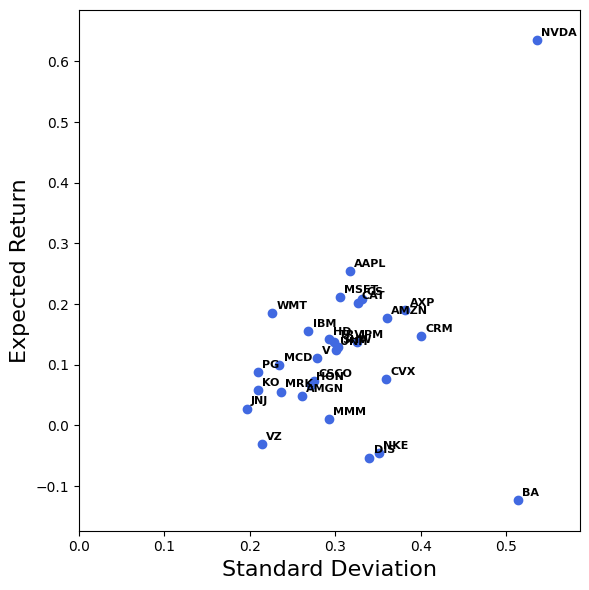

In [3]:
import matplotlib.pyplot as plt

mu = df_returns.mean() * 252
cov = df_returns.cov() * 252
std = np.sqrt(np.diag(cov))

plt.figure(figsize=(6, 6))
plt.scatter(std, mu, c='royalblue', label='Assets')
for symbol, s, m in zip(mu.index, std, mu):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std.max() + 0.05)
plt.ylim(mu.min() - 0.05, mu.max() + 0.05)
plt.tight_layout()
plt.savefig('Asset Allocation_Individual Assets.png', dpi=144, transparent=True)
plt.show()

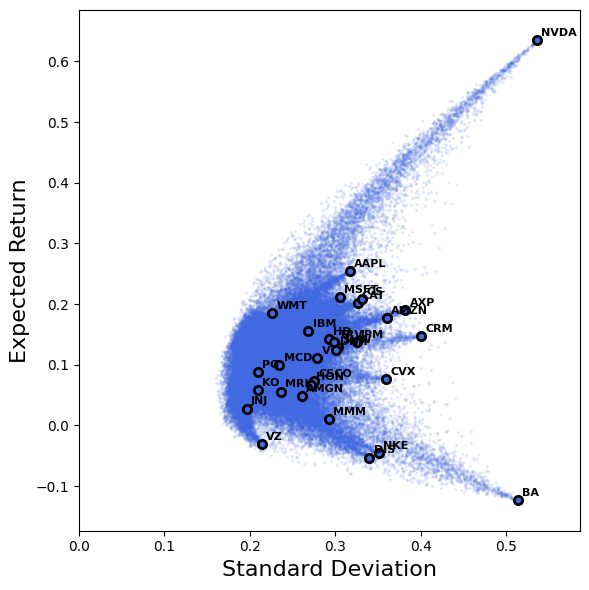

In [ ]:
num_portfolios = 100000
alpha = 0.05

weights = np.random.dirichlet(np.full(len(symbols), alpha), num_portfolios)
portfolio_returns_random = weights @ mu
portfolio_volatility_random = np.sqrt(np.einsum('ij,ji->i', weights @ cov, weights.T))

portfolios_df = pd.DataFrame({'Volatility': portfolio_volatility_random, 'Return': portfolio_returns_random})

plt.figure(figsize=(6, 6))
plt.scatter(portfolios_df['Volatility'], portfolios_df['Return'], s=2, c='royalblue', alpha=0.1, label='Random Portfolios')

plt.scatter(std, mu, facecolors='royalblue', edgecolors='k', label='Assets', linewidths=2)
for symbol, s, m in zip(mu.index, std, mu):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', 
                 fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std.max() + 0.05)
plt.ylim(mu.min() - 0.05, mu.max() + 0.05)
plt.tight_layout()
plt.savefig('Asset Allocation_Monte Carlo.png', dpi=144, transparent=True)
plt.show()

In [6]:
from scipy.optimize import minimize

def portfolio_variance(w, cov):
    return w @ cov @ w

def get_weights(mu, cov, target_mu=None):
    n = len(mu)
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    if target_mu is not None:
        constraints.append({'type': 'eq', 'fun': lambda w: w @ mu - target_mu})
    bounds = [(0, None)] * n
    initial_weights = np.ones(n) / n
    result = minimize(portfolio_variance, initial_weights, args=(cov,), 
                      constraints=constraints, bounds=bounds)
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization did not converge")

def gmvp_weight(mu, cov):
    return get_weights(mu, cov)

def mvp_weight(mu, cov, target_mu):
    return get_weights(mu, cov, target_mu)

In [ ]:
mu_targets = np.linspace(mu.min(), mu.max(), 100)

portfolio_weights = [mvp_weight(mu, cov, target) for target in mu_targets]
portfolio_mu = [w @ mu for w in portfolio_weights]
portfolio_std = [np.sqrt(w @ cov @ w) for w in portfolio_weights]

# GMVP
gmvp = gmvp_weight(mu, cov)
gmvp_mu = gmvp @ mu
gmvp_std = np.sqrt(gmvp @ cov @ gmvp)

plt.figure(figsize=(6, 6))
plt.scatter(portfolio_std, portfolio_mu, c='royalblue', label='Efficient Frontier', s=10)
plt.plot(portfolio_std, portfolio_mu, color='royalblue', linewidth=0.5)
plt.scatter(gmvp_std, gmvp_mu, c='white', s=600, marker='*', label='GMVP', edgecolors='k', linewidth=3)
plt.scatter(portfolios_df['Volatility'], portfolios_df['Return'], s=2, c='royalblue', alpha=0.1, label='Random Portfolios')

plt.scatter(std, mu, facecolors='royalblue', edgecolors='k', label='Assets', linewidths=2)

for symbol, s, m in zip(mu.index, std, mu):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std.max() + 0.05)
plt.ylim(mu.min() - 0.05, mu.max() + 0.05)
plt.tight_layout()
plt.savefig('Asset Allocation_MVP.png', dpi=144, transparent=True)
plt.show()

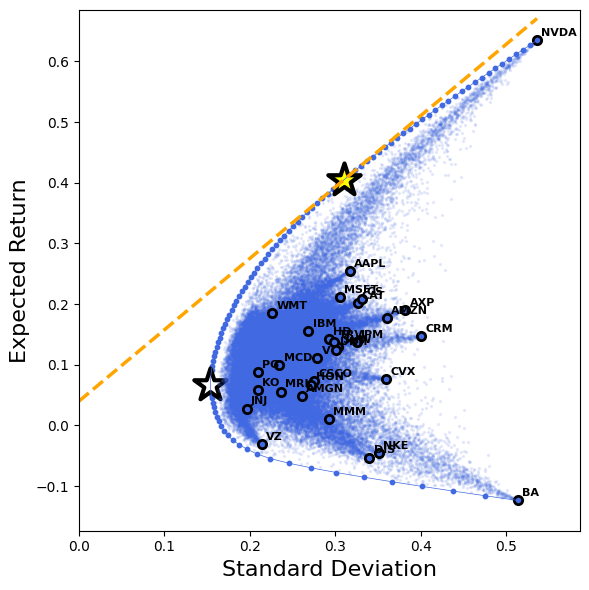

In [42]:
rf = 0.04

sharpe_ratios = (np.array(portfolio_mu) - rf) / np.array(portfolio_std)
max_sharpe_index = sharpe_ratios.argmax()
tangency_return = portfolio_mu[max_sharpe_index]
tangency_risk = portfolio_std[max_sharpe_index]

cal_x = np.linspace(0, max(portfolio_std), 100)
cal_y = rf + sharpe_ratios[max_sharpe_index] * cal_x

plt.figure(figsize=(6, 6))

plt.scatter(portfolio_std, portfolio_mu, c='royalblue', label='Efficient Frontier', s=10)
plt.plot(portfolio_std, portfolio_mu, color='royalblue', linewidth=0.5)

plt.scatter(gmvp_std, gmvp_mu, c='white', s=600, marker='*', label='GMVP', edgecolors='k', linewidth=3)

plt.scatter(portfolios_df['Volatility'], portfolios_df['Return'], s=2, c='royalblue', alpha=0.1, label='Random Portfolios')

plt.scatter(std, mu, facecolors='royalblue', edgecolors='k', label='Assets', linewidths=2)

plt.plot(cal_x, cal_y, color='orange', linewidth=2.5, linestyle='--', label='Capital Allocation Line (CAL)')

plt.scatter(tangency_risk, tangency_return, c='yellow', s=600, marker='*', label='Tangency Portfolio', edgecolors='k', linewidth=3)

for symbol, s, m in zip(mu.index, std, mu):
    plt.annotate(symbol, (s, m), xytext=(3, 3), textcoords='offset points', fontsize=8, fontweight='bold')

plt.xlabel("Standard Deviation", fontsize=16)
plt.ylabel("Expected Return", fontsize=16)
plt.xlim(0, std.max() + 0.05)
plt.ylim(mu.min() - 0.05, mu.max() + 0.05)
plt.tight_layout()
plt.show()